In [1]:
import json
import requests
import numpy as np
import pandas as pd
import os
import pdb

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(97)

In [2]:
# from S26 of https://www.biorxiv.org/content/10.1101/2024.05.05.592437v1.supplementary-material
# last 7 lines are extra accessions for GM12878 which was not used in the paper for some reason (from S1 of https://www.biorxiv.org/content/10.1101/2023.08.08.552077v1.supplementary-material)
all_variant_effect_file_ids = [
    "ENCFF244UZB",
    "ENCFF723IJU",
    "ENCFF190GIK",
    "ENCFF513ZUR",
    "ENCFF104BLT",
    "ENCFF590WME",
    "ENCFF484NRP",
    "ENCFF658YTB",
    "ENCFF687ONV",
    "ENCFF660AQG",
    "ENCFF467ZQU",
    "ENCFF356VJF",
    "ENCFF565QYI",
    "ENCFF409HLO",
    "ENCFF161KFE",
    "ENCFF529TSC",
    "ENCFF514YKU",
    "ENCFF629BDS",
    "ENCFF793IQS",
    "ENCFF153VGD",
    "ENCFF412MJB",
    "ENCFF162EAI",
    "ENCFF684JVF",
    "ENCFF545XTD",
    "ENCFF425QDZ",
    "ENCFF405HLW",
    "ENCFF438TIX",
    "ENCFF425JFH",
    "ENCFF409FRY",
    "ENCFF471LFG",
    "ENCFF320QAF",
    "ENCFF810EGX",
    "ENCFF142YIU",
    "ENCFF592VHT",
    "ENCFF796IFY",
    "ENCFF725MUJ",
    "ENCFF249SXJ",
    "ENCFF902IXC",
    "ENCFF719QDC",
    "ENCFF178TFM",
    "ENCFF551TPN",
    "ENCFF289ORE",
]

In [3]:
# download dir
data_dir = "/clusterfs/nilah/aniketh/Malinois"
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

In [4]:
if not os.path.exists(os.path.join(data_dir, "variant_effects_file_info.csv")):
    # Force return from the server in JSON format
    headers = {"accept": "application/json"}

    data_df = {}
    data_df["cell"] = []
    data_df["dataset_id"] = []
    data_df["element_references_id"] = []
    data_df["variant_effect_quantifications_id"] = []

    for file_id in all_variant_effect_file_ids:
        url = "https://www.encodeproject.org/files/" + file_id + "/?format=json"

        # GET the count file details
        response = requests.get(url, headers=headers).json()
        dataset_id = response["dataset"]

        data_df["cell"].append(response["biosample_ontology"]["term_name"])
        data_df["dataset_id"].append(dataset_id)

        dataset_url = f"https://www.encodeproject.org/{dataset_id}?format=json"

        # GET the dataset details
        response = requests.get(dataset_url, headers=headers).json()

        # extract element references
        element_references_ids = []
        for element_reference in response["elements_references"]:
            element_references_ids.append(element_reference["files"][0]["accession"])
        if (
            len(element_references_ids) > 1
        ):  # one K562 experiment has multiple element libraries (ENCSR971PLA)
            print(dataset_id)
        data_df["element_references_id"].append(";".join(element_references_ids))

        # extract variant effect quantifications
        variant_effect_quantifications_id = None
        assert_one = False
        for file in response["files"]:
            if (
                file["output_type"] == "variant effect quantifications"
                and file["file_format"] == "tsv"
                and file["analysis_step_version"]["analysis_step"]["pipelines"][0][
                    "title"
                ]
                == "Tewhey Lab MPRA Pipeline (MPRAmodel)"
            ):
                # if "assembly" in file and file["assembly"] == "hg19":
                #     continue
                if assert_one:
                    raise Exception(
                        "ERROR: More than one TSV element quantification file found"
                    )
                variant_effect_quantifications_id = file["accession"]
                assert_one = True
        assert assert_one
        data_df["variant_effect_quantifications_id"].append(
            variant_effect_quantifications_id
        )

        # download references and quantifications
        for element_reference_id in element_references_ids:
            element_references_download_url = f"https://www.encodeproject.org/files/{element_reference_id}/@@download/{element_reference_id}.fasta.gz"
            element_references_download_path = os.path.join(
                data_dir, f"{element_reference_id}.fasta.gz"
            )
            os.system(
                f"wget -O {element_references_download_path} {element_references_download_url}"
            )
            os.system(f"gzip -d {element_references_download_path}")

        variant_effect_quantifications_url = f"https://www.encodeproject.org/files/{variant_effect_quantifications_id}/@@download/{variant_effect_quantifications_id}.tsv"
        variant_effect_quantifications_download_path = os.path.join(
            data_dir, f"{variant_effect_quantifications_id}.tsv"
        )
        # os.system(f"wget -O {variant_effect_quantifications_download_path} {variant_effect_quantifications_url}")

    data_df = pd.DataFrame(data_df)
    data_df.to_csv(os.path.join(data_dir, "variant_effects_file_info.csv"), index=False)

data_df = pd.read_csv(os.path.join(data_dir, "variant_effects_file_info.csv"))
data_df

,cell,dataset_id,element_references_id,variant_effect_quantifications_id
0,A549,/functional-characterization-experiments/ENCSR...,ENCFF715XTT,ENCFF244UZB
1,HepG2,/functional-characterization-experiments/ENCSR...,ENCFF715XTT,ENCFF723IJU
2,K562,/functional-characterization-experiments/ENCSR...,ENCFF715XTT,ENCFF190GIK
3,SK-N-SH,/functional-characterization-experiments/ENCSR...,ENCFF715XTT,ENCFF513ZUR
4,A549,/functional-characterization-experiments/ENCSR...,ENCFF384XZU,ENCFF104BLT
5,HepG2,/functional-characterization-experiments/ENCSR...,ENCFF384XZU,ENCFF590WME
6,K562,/functional-characterization-experiments/ENCSR...,ENCFF384XZU,ENCFF484NRP
7,SK-N-SH,/functional-characterization-experiments/ENCSR...,ENCFF384XZU,ENCFF658YTB
8,A549,/functional-characterization-experiments/ENCSR...,ENCFF074MMO,ENCFF687ONV
9,HepG2,/functional-characterization-experiments/ENCSR...,ENCFF074MMO,ENCFF660AQG


In [5]:
for cell in ["K562", "HepG2", "GM12878", "SK-N-SH", "A549"]:
    print(cell)
    cell_data_df = data_df[data_df["cell"] == cell].reset_index(drop=True)
    print(f"Num datasets = {cell_data_df.shape[0]}")

    cell_element_references_df = {}
    cell_element_references_df["ID"] = []
    cell_element_references_df["sequence"] = []

    for i in range(cell_data_df.shape[0]):
        row = cell_data_df.iloc[i]
        element_references_ids = row["element_references_id"]
        print(row["element_references_id"])

        for element_reference_id in element_references_ids.split(";"):
            f = open(
                os.path.join(data_dir, f"{element_reference_id}.fasta"), "r"
            ).readlines()

            for line in f:
                if len(line.strip()) == 0:
                    continue
                if line.startswith(">"):
                    cell_element_references_df["ID"].append(line[1:].strip())
                else:
                    cell_element_references_df["sequence"].append(line.strip())

    cell_element_references_df = (
        pd.DataFrame(cell_element_references_df)
        .drop_duplicates()
        .reset_index(drop=True)
    )
    print(f"Num element references = {cell_element_references_df.shape[0]}")

    cell_variant_effect_quantifications_df = {}
    cell_variant_effect_quantifications_df["ref_ID"] = []
    cell_variant_effect_quantifications_df["alt_ID"] = []
    cell_variant_effect_quantifications_df[f"{cell}_Log2Skew"] = []

    for i in range(cell_data_df.shape[0]):
        row = cell_data_df.iloc[i]
        variant_effect_quantifications_id = row["variant_effect_quantifications_id"]
        df = pd.read_csv(
            os.path.join(data_dir, f"{variant_effect_quantifications_id}.tsv"), sep="\t"
        )
        cell_variant_effect_quantifications_df["ref_ID"].extend(df["ID"].tolist())
        cell_variant_effect_quantifications_df["alt_ID"].extend(
            [e.replace(":R:", ":A:") for e in df["ID"].tolist()]
        )
        cell_variant_effect_quantifications_df[f"{cell}_Log2Skew"].extend(
            df["Log2Skew"].tolist()
        )

    cell_variant_effect_quantifications_df = (
        pd.DataFrame(cell_variant_effect_quantifications_df)
        .drop_duplicates()
        .reset_index(drop=True)
    )
    cell_variant_effect_quantifications_df = (
        cell_variant_effect_quantifications_df[
            (~np.isnan(cell_variant_effect_quantifications_df[f"{cell}_Log2Skew"]))
            & (~np.isinf(cell_variant_effect_quantifications_df[f"{cell}_Log2Skew"]))
        ]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    print(
        f"Num variant effect quantifications = {cell_variant_effect_quantifications_df.shape[0]}"
    )

    cell_df = (
        cell_variant_effect_quantifications_df.merge(
            cell_element_references_df, left_on="ref_ID", right_on="ID", how="inner"
        )
        .reset_index(drop=True)
        .drop("ID", axis=1)
        .rename({"sequence": "ref_sequence"}, axis=1)
    )
    cell_df = (
        cell_df.merge(
            cell_element_references_df, left_on="alt_ID", right_on="ID", how="inner"
        )
        .reset_index(drop=True)
        .drop("ID", axis=1)
        .rename({"sequence": "alt_sequence"}, axis=1)
    )
    cell_df = cell_df.groupby(
        by=["ref_ID", "alt_ID", "ref_sequence", "alt_sequence"]
    ).mean()
    cell_df = pd.DataFrame(cell_df.to_records())

    print(f"Final num element quantifications = {cell_df.shape[0]}")

    cell_df.to_csv(
        os.path.join(data_dir, f"{cell}_variant_effect_data.csv"), index=False
    )

K562
Num datasets = 8
ENCFF715XTT
ENCFF384XZU
ENCFF074MMO
ENCFF621JOY
ENCFF431PJJ
ENCFF982GRP
ENCFF436FCK
ENCFF443RYE;ENCFF728XQT
Num element references = 807992


/clusterfs/nilah/aniketh/tmp/ipykernel_1539842/2031209203.py:43: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Num variant effect quantifications = 402421
Final num element quantifications = 357344
HepG2
Num datasets = 9
ENCFF715XTT
ENCFF384XZU
ENCFF074MMO
ENCFF621JOY
ENCFF431PJJ
ENCFF982GRP
ENCFF436FCK
ENCFF443RYE
ENCFF728XQT
Num element references = 807992


/clusterfs/nilah/aniketh/tmp/ipykernel_1539842/2031209203.py:43: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/clusterfs/nilah/aniketh/tmp/ipykernel_1539842/2031209203.py:43: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Num variant effect quantifications = 402742
Final num element quantifications = 357514
GM12878
Num datasets = 7
ENCFF715XTT
ENCFF384XZU
ENCFF074MMO
ENCFF621JOY
ENCFF431PJJ
ENCFF982GRP
ENCFF436FCK
Num element references = 344657
Num variant effect quantifications = 188472
Final num element quantifications = 155283
SK-N-SH
Num datasets = 9
ENCFF715XTT
ENCFF384XZU
ENCFF074MMO
ENCFF621JOY
ENCFF431PJJ
ENCFF982GRP
ENCFF436FCK
ENCFF443RYE
ENCFF728XQT
Num element references = 807992


/clusterfs/nilah/aniketh/tmp/ipykernel_1539842/2031209203.py:43: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/clusterfs/nilah/aniketh/tmp/ipykernel_1539842/2031209203.py:43: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Num variant effect quantifications = 402563
Final num element quantifications = 357342
A549
Num datasets = 7
ENCFF715XTT
ENCFF384XZU
ENCFF074MMO
ENCFF621JOY
ENCFF431PJJ
ENCFF982GRP
ENCFF436FCK
Num element references = 344657
Num variant effect quantifications = 188482
Final num element quantifications = 155288


K562
-0.0033568799603540893 0.5758311151003317 -1.7895598140281917e-18 1.0000000000000002
Num measurements = 357344
Num total sequences so far = 357344


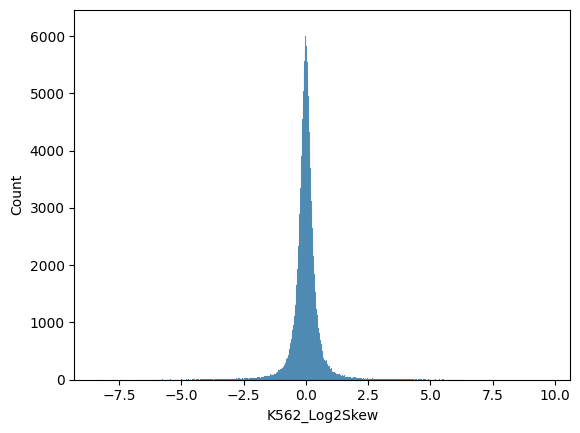

HepG2
-0.004581716602140907 0.5328274013857086 1.907956125717304e-18 1.0000000000000002
Num measurements = 357514
Num total sequences so far = 357746


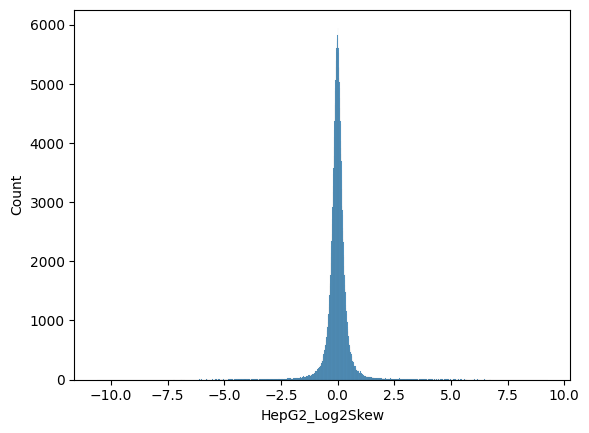

GM12878
-0.0001727212251772538 0.6906821813038522 1.0570079916061845e-17 1.0
Num measurements = 155283
Num total sequences so far = 357746


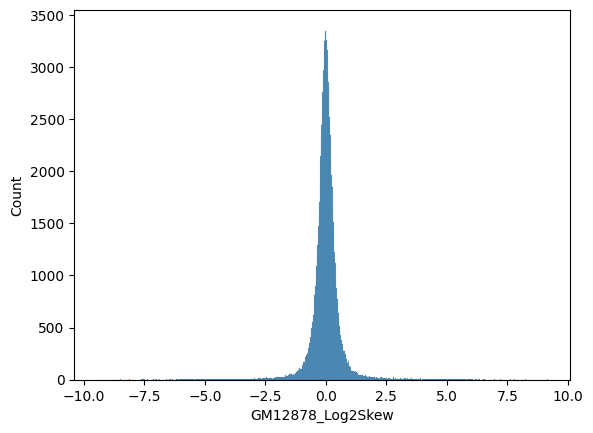

SK-N-SH
-0.00542771691219729 0.6556855064625219 2.6644706357454043e-18 0.9999999999999999
Num measurements = 357342
Num total sequences so far = 357772


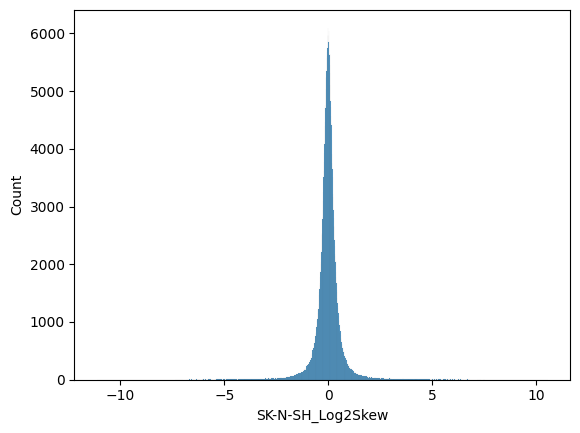

A549
-0.0026292634111836663 0.4612494399996984 4.8501835293500216e-18 0.9999999999999999
Num measurements = 155288
Num total sequences so far = 357772


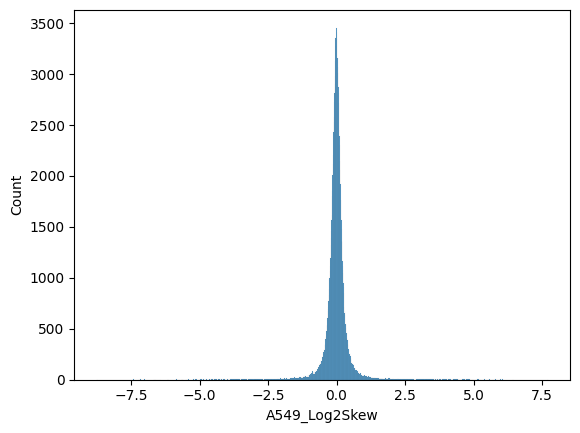

,ref_ID,alt_ID,ref_sequence,alt_sequence,K562_Log2Skew,K562_normalized_variant_effect,HepG2_Log2Skew,HepG2_normalized_variant_effect,GM12878_Log2Skew,GM12878_normalized_variant_effect,SK-N-SH_Log2Skew,SK-N-SH_normalized_variant_effect,A549_Log2Skew,A549_normalized_variant_effect,split
0,6:105479558:A:G:R:wC,6:105479558:A:G:A:wC,AGTGCAGTGGCGCAGTCTTGGCTCACTGCAAGCTCTGCCTCCCAGG...,AGTGCAGTGGCGCAGTCTTGGCTCACTGCAAGCTCTGCCTCCCAGG...,-0.079077,-0.131497,0.092621,0.182429,-0.090364,-0.130583,0.013286,0.028540,0.140950,0.311284,test
1,5:134772074:AGACTAAGGTGTATTGT:A:R:wC,5:134772074:AGACTAAGGTGTATTGT:A:A:wC,CAAAGAAAAAGTATTTGATGAATACTTTGAAGTATTACATTAACCA...,CAAAGAAAAAGTATTTGATGAATACTTTGAAGTATTACATTAACCA...,-1.294005,-2.241366,-0.581003,-1.081815,NaN,NaN,-0.798746,-1.209907,NaN,NaN,test
2,18:67983243:C:A:R:wC,18:67983243:C:A:A:wC,TTGCCCAGGCTGGAGTGCAGTGGCGCGATCTTGGCTCACTGCAACC...,TTGCCCAGGCTGGAGTGCAGTGGCGCGATCTTGGCTCACTGCAACC...,-0.083007,-0.138321,-0.265229,-0.489177,NaN,NaN,-0.078355,-0.111222,NaN,NaN,test
3,13:67311727:T:C:R:wC,13:67311727:T:C:A:wC,AGATGGCCGAATAGGAACAGCTCCGGTCTACAGCTCCCAGCGTGAG...,AGATGGCCGAATAGGAACAGCTCCGGTCTACAGCTCCCAGCGTGAG...,0.438687,0.767662,1.031662,1.944802,0.229993,0.333244,0.682414,1.049042,0.269050,0.589008,test
4,16:18601266:A:G:R:wC,16:18601266:A:G:A:wC,GGGTGACAAGAGCGAAACTCCGTCTCAAAAAAAAAAAAAAAAAGAA...,GGGTGACAAGAGCGAAACTCCGTCTCAAAAAAAAAAAAAAAAAGAA...,-0.174926,-0.297950,-0.052912,-0.090706,NaN,NaN,-0.315117,-0.472314,NaN,NaN,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357767,12:2951370:G:A:R:wC,12:2951370:G:A:A:wC,TAATTTCACTTGTTTCTTTTTTTTTTTTTTTTTTTGAGATGGAGTC...,TAATTTCACTTGTTTCTTTTTTTTTTTTTTTTTTTGAGATGGAGTC...,0.125124,0.223123,-0.063568,-0.110704,NaN,NaN,0.000808,0.009510,NaN,NaN,train
357768,6:111914825:G:A:R:wC,6:111914825:G:A:A:wC,CTCCACTCCCTGCCAAATGAATGCTCTTTGACAGTCTTCTCCCACT...,CTCCACTCCCTGCCAAATGAATGCTCTTTGACAGTCTTCTCCCACT...,-1.335921,-2.314157,-1.077852,-2.014292,-0.608965,-0.881437,-1.484946,-2.256446,-1.183409,-2.559960,train
357769,16:24593429:T:C:R:wC,16:24593429:T:C:A:wC,ATGAGCCACAATTGACTTTAGCAACACCCACACACATACACCTCTA...,ATGAGCCACAATTGACTTTAGCAACACCCACACACATACACCTCTA...,0.092844,0.167064,0.122525,0.238551,-0.111375,-0.161003,0.434360,0.670729,0.121827,0.269825,train
357770,9:104184022:G:A:R:wC,9:104184022:G:A:A:wC,GTTTCAATAACTGATTTATTTTTTCCCCCTTGTACTTAAGATTTAA...,GTTTCAATAACTGATTTATTTTTTCCCCCTTGTACTTAAGATTTAA...,0.083581,0.150978,-0.225866,-0.415302,NaN,NaN,-0.281405,-0.420899,NaN,NaN,train


In [6]:
# this is the file used for fine-tuning

test_frac = 0.05
val_frac = 0.05

union_df = None
for cell in ["K562", "HepG2", "GM12878", "SK-N-SH", "A549"]:
    print(cell)
    cell_df = pd.read_csv(os.path.join(data_dir, f"{cell}_variant_effect_data.csv"))
    mean_variant_effect = cell_df[f"{cell}_Log2Skew"].mean()
    std_variant_effect = cell_df[f"{cell}_Log2Skew"].std()
    cell_df[f"{cell}_normalized_variant_effect"] = (
        cell_df[f"{cell}_Log2Skew"] - mean_variant_effect
    ) / std_variant_effect
    print(
        mean_variant_effect,
        std_variant_effect,
        cell_df[f"{cell}_normalized_variant_effect"].mean(),
        cell_df[f"{cell}_normalized_variant_effect"].std(),
    )
    print(f"Num measurements = {cell_df.shape[0]}")
    if union_df is None:
        union_df = cell_df.copy()
    else:
        union_df = union_df.merge(
            cell_df,
            on=["ref_ID", "alt_ID", "ref_sequence", "alt_sequence"],
            how="outer",
        ).reset_index(drop=True)
    print(f"Num total sequences so far = {union_df.shape[0]}")
    sns.histplot(data=cell_df, x=f"{cell}_Log2Skew")
    plt.show()
union_df = union_df.sample(frac=1, replace=False, random_state=97, ignore_index=True)

n_test = int(np.ceil(test_frac * union_df.shape[0]))
n_val = int(np.ceil(val_frac * union_df.shape[0]))
splits = (
    ["test" for _ in range(n_test)]
    + ["val" for _ in range(n_val)]
    + ["train" for _ in range(union_df.shape[0] - n_test - n_val)]
)
assert len(splits) == union_df.shape[0]
union_df["split"] = splits

union_df.to_csv(
    os.path.join(data_dir, "all_sequences_variant_effect_data.csv"), index=False
)
union_df

In [7]:
intersection_df = None
for cell in ["K562", "HepG2", "GM12878", "SK-N-SH", "A549"]:
    print(cell)
    cell_df = pd.read_csv(os.path.join(data_dir, f"{cell}_variant_effect_data.csv"))
    mean_variant_effect = cell_df[f"{cell}_Log2Skew"].mean()
    std_variant_effect = cell_df[f"{cell}_Log2Skew"].std()
    cell_df[f"{cell}_normalized_variant_effect"] = (
        cell_df[f"{cell}_Log2Skew"] - mean_variant_effect
    ) / std_variant_effect
    print(
        mean_variant_effect,
        std_variant_effect,
        cell_df[f"{cell}_normalized_variant_effect"].mean(),
        cell_df[f"{cell}_normalized_variant_effect"].std(),
    )
    print(f"Num measurements = {cell_df.shape[0]}")
    if intersection_df is None:
        intersection_df = cell_df.copy()
    else:
        intersection_df = intersection_df.merge(
            cell_df,
            on=["ref_ID", "alt_ID", "ref_sequence", "alt_sequence"],
            how="inner",
        ).reset_index(drop=True)
    print(f"Num common measurements so far = {intersection_df.shape[0]}")
intersection_df.to_csv(
    os.path.join(data_dir, "common_sequences_variant_effect_data.csv"), index=False
)
intersection_df

K562
-0.0033568799603540893 0.5758311151003317 -1.7895598140281917e-18 1.0000000000000002
Num measurements = 357344
Num common measurements so far = 357344
HepG2
-0.004581716602140907 0.5328274013857086 1.907956125717304e-18 1.0000000000000002
Num measurements = 357514
Num common measurements so far = 357112
GM12878
-0.0001727212251772538 0.6906821813038522 1.0570079916061845e-17 1.0
Num measurements = 155283
Num common measurements so far = 155283
SK-N-SH
-0.00542771691219729 0.6556855064625219 2.6644706357454043e-18 0.9999999999999999
Num measurements = 357342
Num common measurements so far = 155283
A549
-0.0026292634111836663 0.4612494399996984 4.8501835293500216e-18 0.9999999999999999
Num measurements = 155288
Num common measurements so far = 155283


,ref_ID,alt_ID,ref_sequence,alt_sequence,K562_Log2Skew,K562_normalized_variant_effect,HepG2_Log2Skew,HepG2_normalized_variant_effect,GM12878_Log2Skew,GM12878_normalized_variant_effect,SK-N-SH_Log2Skew,SK-N-SH_normalized_variant_effect,A549_Log2Skew,A549_normalized_variant_effect
0,10:100176869:C:T:R:wC,10:100176869:C:T:A:wC,TGTTGGGCTTCAGTGATAACAATGACCAACATTTATTGAGCACCTA...,TGTTGGGCTTCAGTGATAACAATGACCAACATTTATTGAGCACCTA...,-0.354392,-0.609614,-0.059313,-0.102718,0.238269,0.345227,-0.270489,-0.404251,0.211666,0.464597
1,10:100179851:T:C:R:wC,10:100179851:T:C:A:wC,GCGGGAAGTGTGTGTGGCCCGTCCTGGCCCAGGGACTCAGCCTCAC...,GCGGGAAGTGTGTGTGGCCCGTCCTGGCCCAGGGACTCAGCCTCAC...,1.020368,1.777822,0.898265,1.694445,0.840062,1.216529,0.500367,0.771398,0.228495,0.501084
2,10:100194602:A:G:R:wC,10:100194602:A:G:A:wC,TGGGGTCCCTCCCACCTCAGTGTATACTCTGAACCATGATTCTCTT...,TGGGGTCCCTCCCACCTCAGTGTATACTCTGAACCATGATTCTCTT...,0.014259,0.030593,0.126419,0.245860,-0.013124,-0.018751,0.096937,0.156119,0.040065,0.092562
3,10:100219374:T:A:R:wC,10:100219374:T:A:A:wC,TGGAGGAGTGGAAGCAGCCCAGCAGGCCCACTGGTAGCCGTGAGTG...,TGGAGGAGTGGAAGCAGCCCAGCAGGCCCACTGGTAGCCGTGAGTG...,-0.000437,0.005070,-0.304470,-0.562824,-0.592672,-0.857847,0.202362,0.316905,-0.080030,-0.167808
4,10:10023340:A:G:R:wC,10:10023340:A:G:A:wC,GGCTCTCTACAGACATTTTAATAACATGTCAATATTTCTGATCACA...,GGCTCTCTACAGACATTTTAATAACATGTCAATATTTCTGATCACA...,0.083009,0.149984,-0.064997,-0.113387,1.235870,1.789597,0.413497,0.638911,-0.197952,-0.423464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155278,9:99245690:T:C:R:wC,9:99245690:T:C:A:wC,TTTTTGGGGGGAGGGTGGTCATTTGTCTCAACTAAAGAGGACTTGT...,TTTTTGGGGGGAGGGTGGTCATTTGTCTCAACTAAAGAGGACTTGT...,-0.038697,-0.061373,-0.035928,-0.058830,-0.030511,-0.043925,0.001669,0.010824,-0.234177,-0.502002
155279,9:99246159:C:T:R:wC,9:99246159:C:T:A:wC,AGGTTTTCTGCTAAGAGTTTTATATTTTAGCTCTTGTATTTATGGT...,AGGTTTTCTGCTAAGAGTTTTATATTTTAGCTCTTGTATTTATGGT...,0.012163,0.026952,0.099301,0.194965,0.319947,0.463484,0.000015,0.008300,0.038880,0.089993
155280,9:99247301:T:A:R:wC,9:99247301:T:A:A:wC,TTTCTCAAGGGAGAGTTACAGATTGTGTCTTGTACAATTCAGAGTT...,TTTCTCAAGGGAGAGTTACAGATTGTGTCTTGTACAATTCAGAGTT...,-0.658354,-1.137481,0.052284,0.106724,-0.002079,-0.002760,0.015231,0.031507,0.577393,1.257503
155281,9:99288951:A:G:R:wC,9:99288951:A:G:A:wC,CAGCAGATTAATATACCTCTTAATGAATCTCAATTTTCACTGTACA...,CAGCAGATTAATATACCTCTTAATGAATCTCAATTTTCACTGTACA...,-0.360727,-0.620616,0.058569,0.118521,1.011206,1.464318,-1.126622,-1.709957,0.817859,1.778838
